In [44]:
% matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys
import math
import seaborn as sns
import numpy as np
sys.path.append('..')
from helpers.funcs import *

In [4]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
time_dict = json.load(open(INPUT_DIR + "event_year.json","r"))
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))

In [5]:
filtering = ['noRT', 'clustered']
cluster_method = [None, 'relative']
leaveout = [True, False]
method = ['posterior', 'mutual_information', 'chi_square']

In [6]:
def get_filename(f, c, l, m, b):
    cluster_method = method_name(c, c)
    leaveout = method_name(l, 'leaveout')
    filename = 'polarization_' + m + '_' + f + cluster_method + leaveout + '.json'
    if b:
        filename = 'between_topic_' + filename
    return filename

In [7]:
def get_label(e):
    label = e.split('_')
    new_label = []
    for l in label:
        new_label.append(l[0].upper() + l[1:])
    new_label = ' '.join(new_label)
    return new_label

## for plotting overall polarization

In [8]:
def save_csv(polarization_dict, filename):
    x = []
    y = []
    y_random = []
    labels=[]
    ex = ['fort_lauderdale']  # we exclude Fort Lauderdale because we only have data for the first day after the shooting
    for e, t in time_dict.items():
        if e in ex:
            continue
        new_label = get_label(e)

        x_val = float(2000+t)
        y_val = float(polarization_dict[e][0])
        y_random_val = float(float(polarization_dict[e][1]))
        x.append(x_val)
        y.append(y_val)
        y_random.append(y_random_val)
        labels.append(new_label)
        #labels.append(plt.text(x_val, y_val, new_label, fontsize=8))
    df = pd.DataFrame.from_dict({'year':np.array(x * 2), 'polarization':np.array(y + y_random), 'label':labels * 2, 'is_actual':['actual value']* len(y) + ['value resulting from random party assignment']* len(y)})
    df.to_csv(OUTPUT_DIR + filename.replace('.json', '.csv'), index=False)

In [14]:
for m in method:
    for f in filtering:
        for c in cluster_method:
            for l in leaveout:
                for b in [True, False]:
                    filename = get_filename(f, c, l, m, b)
                    try:
                        file = json.load(open(OUTPUT_DIR + filename,"r"))
                    except:
                        continue
                    print(filename, 'found')
                    save_csv(file, filename)

polarization_posterior_noRT_leaveout.json found
polarization_posterior_noRT.json found
between_topic_polarization_posterior_clustered_relative_leaveout.json found
between_topic_polarization_posterior_clustered_relative.json found
polarization_mutual_information_noRT_leaveout.json found
polarization_mutual_information_noRT.json found
between_topic_polarization_mutual_information_clustered_relative_leaveout.json found
between_topic_polarization_mutual_information_clustered_relative.json found
polarization_chi_square_noRT_leaveout.json found
polarization_chi_square_noRT.json found
between_topic_polarization_chi_square_clustered_relative_leaveout.json found
between_topic_polarization_chi_square_clustered_relative.json found


## for plotting within topic polarization

In [35]:
def get_within_topic_values(e, method, leaveout, cluster_method):
    within_topic_pol = json.load(open(TWEET_DIR +e+"/"+e+"_topic_polarization_"+method + cluster_method+leaveout+".json","r"))
    # get the topic proportions
    topics = pd.read_csv(TWEET_DIR + e + '/' + e + '_kmeans_topics_' + str(NUM_CLUSTERS) + '.csv')
    if cluster_method != '':
        _, topics = get_assigned_indices_relative(topics) if cluster_method == '_relative' else get_assigned_indices_absolute(topics)

    within_topic_pol_actual= (np.array([float(within_topic_pol[str(i)][0]) for i in range(NUM_CLUSTERS)]) * np.bincount(topics['topic_0'])).sum() / len(topics)
    within_topic_pol_random = (np.array([float(within_topic_pol[str(i)][1]) for i in range(NUM_CLUSTERS)]) * np.bincount(topics['topic_0'])).sum() / len(topics)
    
    return within_topic_pol_actual, within_topic_pol_random

In [38]:
def save_within_topic_csv(method, leaveout, cluster_method='_relative'):
    print(method, leaveout)
    leaveout = method_name(leaveout, 'leaveout')
    x = []
    y = []
    y_random = []
    labels=[]
    ex = ['fort_lauderdale']  # we exclude Fort Lauderdale because we only have data for the first day after the shooting
    for e, t in time_dict.items():
        if e in ex:
            continue
        new_label = get_label(e)
        
        x_val = float(2000+t)
        y_val, y_random_val = get_within_topic_values(e, method, leaveout, cluster_method)
        x.append(x_val)
        y.append(y_val)
        y_random.append(y_random_val)
        labels.append(new_label)
        #labels.append(plt.text(x_val, y_val, new_label, fontsize=8))
    df = pd.DataFrame.from_dict({'year':np.array(x * 2), 'polarization':np.array(y + y_random), 'label':labels * 2, 'is_actual':['actual value']* len(y) + ['value resulting from random party assignment']* len(y)})
    df.to_csv(OUTPUT_DIR + "within_topic_polarization_"+method+cluster_method+leaveout+".csv", index=False)

In [39]:
for m in method:
    for l in leaveout:
        save_within_topic_csv(m, l)

posterior True
posterior False
mutual_information True
mutual_information False
chi_square True
chi_square False


## for plotting within vs between topic polarization

In [40]:
def save_topic_csv(method, leaveout, cluster_method='_relative'):
    leaveout = method_name(leaveout, 'leaveout')
    try:
        between_topic_filename = 'between_topic_polarization_' + method + '_clustered' + cluster_method + leaveout + '.json'
        between_topic_pol = json.load(open(OUTPUT_DIR + between_topic_filename,"r"))
        print(between_topic_filename)
    except:
        return
    x = []
    y_between = []
    y_within = []
    labels=[]
    race = []
    ex = ['fort_lauderdale']
    for e, t in time_dict.items():
        if e in ex:
            continue
        new_label = get_label(e)
        x_val = float(2000+t)
        y_between_val = float(between_topic_pol[e][0])
        y_within_val, _ = get_within_topic_values(e, method, leaveout, cluster_method)
        x.append(x_val)
        y_between.append(y_between_val)
        y_within.append(y_within_val)
        labels.append(new_label)
        race.append(shooter_race[e])
        #labels.append(plt.text(x_val, y_val, new_label, fontsize=8))
    df = pd.DataFrame.from_dict({'year':np.array(x * 2), 'polarization':np.array(y_between + y_within), 'label':labels * 2, 'kind':['between-topic']* len(y_between) + ['within-topic']* len(y_within), 'race':race * 2})
    df.to_csv(OUTPUT_DIR + "topic_polarization_"+method+cluster_method+leaveout+".csv", index=False)

In [11]:
for m in method:
    for l in leaveout:
        save_topic_csv(m, l)

between_topic_polarization_posterior_clustered_relative_leaveout.json
between_topic_polarization_posterior_clustered_relative.json
between_topic_polarization_mutual_information_clustered_relative_leaveout.json
between_topic_polarization_mutual_information_clustered_relative.json
between_topic_polarization_chi_square_clustered_relative_leaveout.json
between_topic_polarization_chi_square_clustered_relative.json


## combine polarization over time values

In [41]:
def save_temporal_csv(method, leaveout):
    dicts = []
    for e in events:
        vals = np.load(TWEET_DIR + e + '/' + e + '_polarization_over_time_noRT.npy')
        label = e.split('_')
        new_label = []
        for l in label:
            new_label.append(l[0].upper() + l[1:])
        new_label = ' '.join(new_label)
        for i in range(vals.shape[0]):
            d = {}
            d['event'] = new_label
            d['leaveout'] = vals[i, 0]
            d['time'] = vals[i, 3]
            d['size'] = vals[i, 2]
            d['squared_diff'] = np.abs(vals[i, 1] - .5)
            dicts.append(d)
    df = pd.DataFrame(dicts)
    df.to_csv(OUTPUT_DIR + 'temporal_polarization_'+method+'_noRT.csv', index=False)

In [43]:
for m in method:
    print(m)
    save_temporal_csv(m, True)

posterior
mutual_information
chi_square


In [73]:
df = pd.read_csv(OUTPUT_DIR + 'temporal_polarization_posterior_noRT.csv')

In [74]:
df['over_random'] = df['leaveout'] / .5

In [75]:
df = df[df['squared_diff'] < 0.05]
#df = df[df['event'].isin(['Vegas', 'Orlando'])]

In [79]:
df[df['event'] == 'Vegas']

,event,leaveout,size,squared_diff,time,over_random
120,Vegas,0.532192,326987.0,0.000068,1.0,1.064384
121,Vegas,0.543046,116050.0,0.000221,2.0,1.086092
122,Vegas,0.543513,69787.0,0.000504,3.0,1.087025
123,Vegas,0.542220,47815.0,0.000700,4.0,1.084439
124,Vegas,0.548898,29459.0,0.000698,5.0,1.097796
125,Vegas,0.559574,18544.0,0.000144,6.0,1.119148
126,Vegas,0.557199,17056.0,0.000011,7.0,1.114399
127,Vegas,0.548795,16231.0,0.001126,8.0,1.097590
128,Vegas,0.559147,13370.0,0.001163,9.0,1.118294
129,Vegas,0.564666,11443.0,0.000788,10.0,1.129332


In [71]:
df.groupby('time').mean()

,leaveout,size,squared_diff
time,,,
1.0,0.527534,46933.523810,0.000526
2.0,0.533188,20351.428571,0.001061
3.0,0.541436,11659.238095,0.004103
4.0,0.533888,7094.190476,0.007060
5.0,0.530235,4993.809524,0.001950
6.0,0.538207,3732.523810,0.003954
7.0,0.523617,2764.666667,0.006683
8.0,0.523772,2820.190476,0.003956
9.0,0.530502,2907.380952,0.004546


In [68]:
df[df['time']==10].mean() / df[df['time']==1].mean()

leaveout         1.074689
size             0.046482
squared_diff     7.468382
time            10.000000
dtype: float64

## combine user leaveout scores (this is not used in the paper)

In [6]:
dfs = []
for e in events:
    df = pd.read_csv(TWEET_DIR + e + '/' + e + '_user_leaveout.csv')
    df['event'] = e
    dfs.append(df)

In [7]:
new = pd.concat(dfs, ignore_index=True)

In [9]:
new.to_csv(TWEET_DIR + 'user_leaveouts.csv', index=False)

# plot LO vs MLE size diff

In [33]:
post_lo = json.load(open(OUTPUT_DIR + get_filename('noRT', None, True, 'posterior', False), 'r'))
post_mle = json.load(open(OUTPUT_DIR +get_filename('noRT', None, False, 'posterior', False), 'r'))

In [28]:
def get_diff(d):
    size = []
    diff = []
    for k, v in d.items():
        size.append(np.log(v[2]))
        diff.append(np.abs(.5-v[1]))
    return pd.DataFrame({'size': size, 'diff': diff})

In [40]:
size = []
diff = []
for k, v in post_lo.items():
    size.append(np.log(v[2]))
    diff.append(post_mle[k][1]-v[1])
diff = pd.DataFrame({'size': size, 'diff': diff})

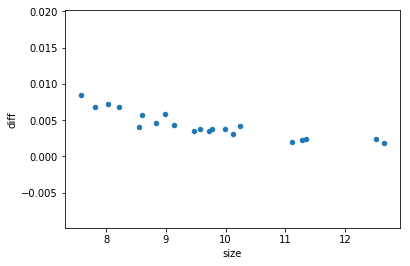

In [41]:
diff.plot.scatter('size', 'diff')

<Figure size 1800x1200 with 0 Axes>

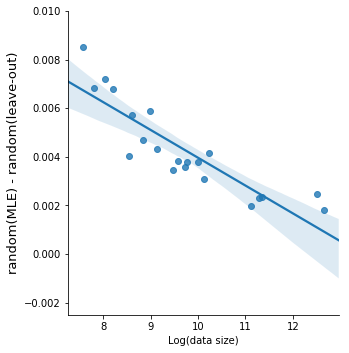

In [52]:
f = plt.figure(dpi=300)
sns.lmplot('size', 'diff', data=diff)
plt.xlabel('Log(data size)')
plt.ylabel('random(MLE) - random(leave-out)', fontsize=13)
plt.ylim(-0.0025, 0.01)
plt.show()